In [181]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.base.model
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
import ml_metrics as metrics
from itertools import product
from tqdm import tqdm

In [182]:
def show_plot(df):
    plt.figure(figsize=(12, 7))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    df.plot(ax=ts_ax)
    smt.graphics.plot_acf(df, lags=30, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(df, lags=30, ax=pacf_ax, alpha=0.5)

    plt.tight_layout()

In [183]:
def decomposition(df, model):
    plt.figure(figsize=(12, 7))
    r = statsmodels.tsa.seasonal.seasonal_decompose(df['Value'], model=model) 
    plt.plot(r.seasonal, c='red', label='Seasonal component')
    plt.plot(r.trend, label='Trend')
    plt.plot(r.resid, c='grey', label='Lags')
    plt.legend(loc='upper left')    

In [272]:
df = pd.read_csv('training.csv', ",", parse_dates=['Date'], dayfirst=True)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,index,Value
Date,,
1959-01-01,0,22.8331
1959-02-01,1,23.2802
1959-03-01,2,23.6156
1959-04-01,3,24.1186
1959-05-01,4,24.4820


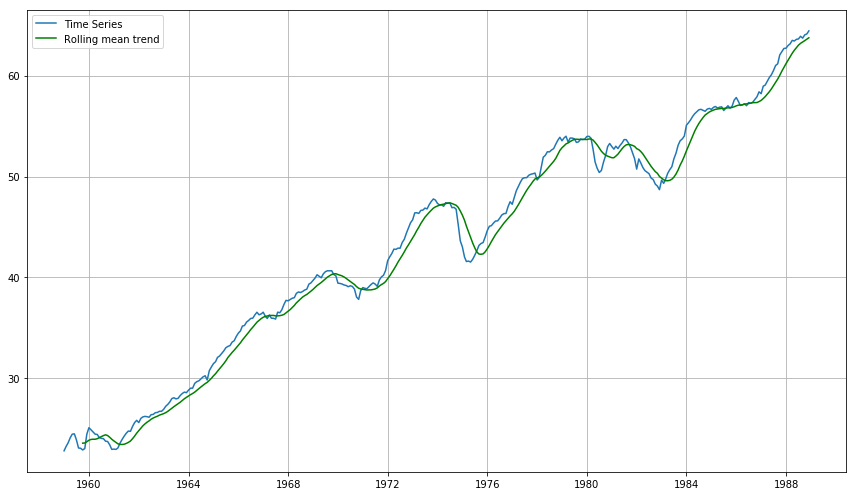

In [273]:
plt.figure(figsize=(12,7))
plt.plot(df['Value'], label="Time Series")

rolling_mean = df['Value'].rolling(window=10).mean()

plt.plot(rolling_mean, "g", label="Rolling mean trend")
plt.legend(loc="upper left")


plt.grid(True)
plt.tight_layout()


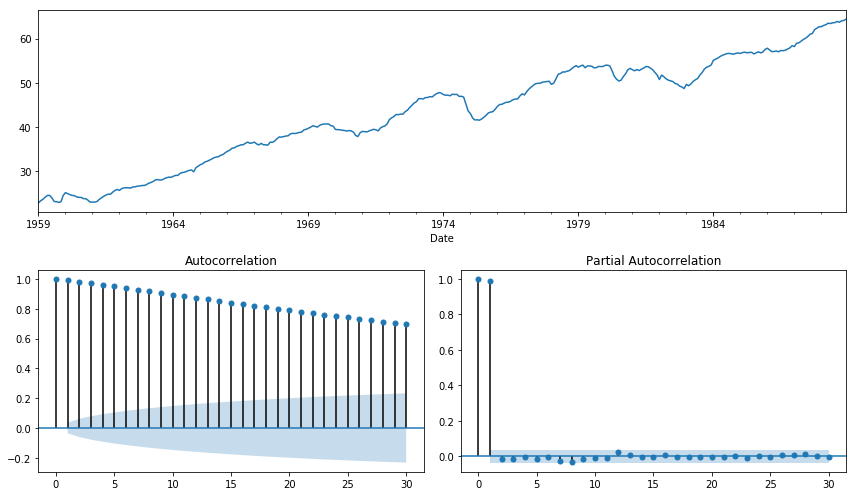

In [274]:
show_plot(df['Value'])

## Аддитивная модель

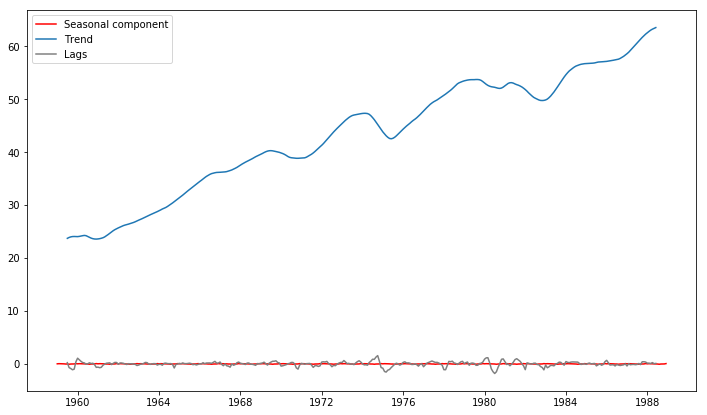

In [275]:
decomposition(df, 'additive')

## Мультипликативная модель

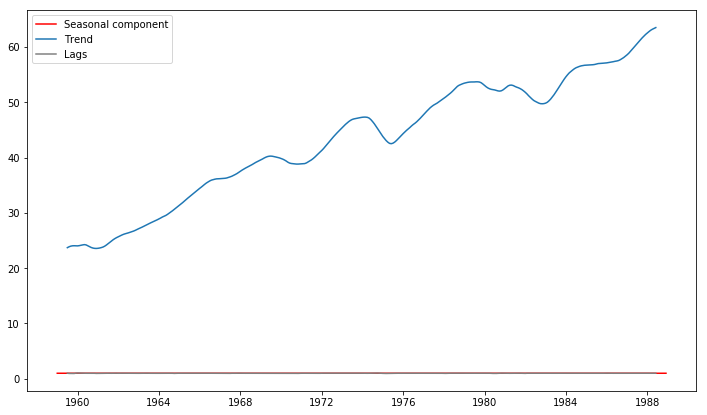

In [276]:
decomposition(df, 'multiplicative')

Заметим, что в мультипликативной модели меньше разброс ошибок

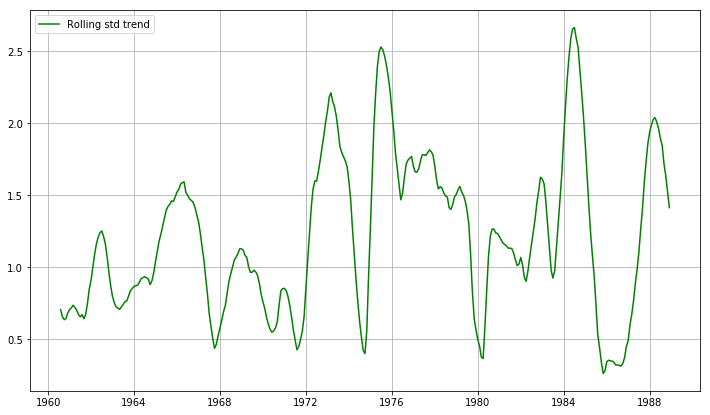

In [189]:
plt.figure(figsize = (12, 7))
rolling_std = df['Value'].rolling(window=20).std()
plt.plot( rolling_std, "g", label="Rolling std trend")
plt.legend(loc="upper left")
plt.grid(True)

In [277]:
df['Value'] = df['Value'].dropna()
test = sm.tsa.adfuller(df['Value'])
print ( 'adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
есть единичные корни, ряд не стационарен


In [278]:
df1 = df['Value'].diff(periods=1).dropna()
df1.head()

Date
1959-02-01    0.4471
1959-03-01    0.3354
1959-04-01    0.5030
1959-05-01    0.3634
1959-06-01    0.0279
Name: Value, dtype: float64

In [279]:
test = sm.tsa.adfuller(df1)
print ( 'adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.36731149521
p-value:  9.1641495611e-11
Critical values:  {'1%': -3.4489583388155194, '5%': -2.869739378430086, '10%': -2.5711381780459002}
единичных корней нет, ряд стационарен


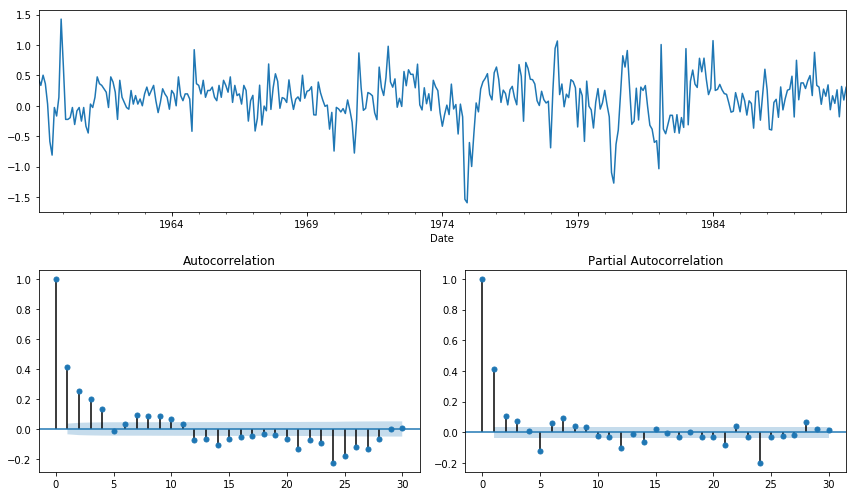

In [281]:
show_plot(df1) #интегрированный ряд первого порядка, его автокореляция и частичная автокорелляция

In [282]:
train, test = df.Value[0:-30], df.Value[329:]

### Эта херня не работает, r2_score лучше не становится

In [266]:
ps = range(0, 5)
qs = range(0, 4)
tr = range(0, 2)


parameters = product(ps, qs)
parameters_list = list(parameters)

predictions = list()
#results = []
best_aic = float("inf")


for param in tqdm(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        #model = sm.tsa.SARIMAX(train, order=(param[0],1,param[1]), trend = [1,1,1,1]).fit()
        model=sm.tsa.ARIMA(train, order=(param[0], 1, param[1])).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        #results.append([param, model.aic])


100%|██████████| 20/20 [00:02<00:00,  7.03it/s]


In [267]:
print(best_aic, best_param)

238.59805326613593 (3, 2)


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  329
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -112.299
Method:                       css-mle   S.D. of innovations              0.340
Date:                Tue, 21 Nov 2017   AIC                            238.598
Time:                        12:38:10   BIC                            265.170
Sample:                    02-01-1959   HQIC                           249.199
                         - 06-01-1986                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1046      0.037      2.818      0.005       0.032       0.177
ar.L1.D.Value     0.4501      0.279      1.612      0.108      -0.097       0.997
ar.L2.D.Value    -0.6051      0.191     

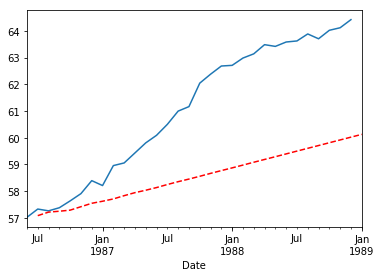

In [283]:
model = sm.tsa.ARIMA(train, order=(3,1,2)).fit()
print(model.summary())

pred = model.predict(start=330, end=360, typ='levels')
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(pred, test))
test.plot()
pred.plot(style='r--')

R^2: 0.99
0.282365604666


/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


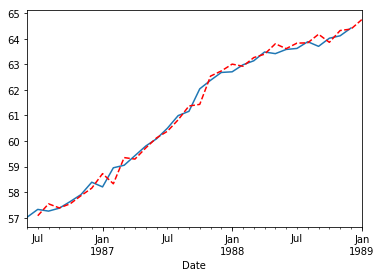

In [284]:
model1 = sm.tsa.SARIMAX(df.Value, order=(1,1,1), trend=[1,1,1,1]).fit()

pred = model1.predict(start=330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

test.plot()
pred.plot(style='r--')

/home/anna/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


R^2: 0.46
1.83823947022


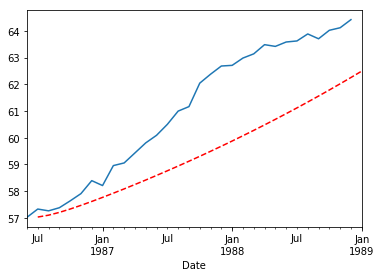

In [285]:
model1 = sm.tsa.SARIMAX(train, order=(1,1,1), trend=[1,1,1,1]).fit()
pred = model1.predict(start = 330, end=360)
r2 = r2_score(test, pred)
print ('R^2: %1.2f' % r2)
print(metrics.rmse(test,pred))

test.plot()
pred.plot(style='r--')

In [265]:
model1.aic

245.65672560155119